In [1]:
from gwdetectors import *
from postprocessing import * 
from Functions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import glob
from decimal import Decimal

In [2]:
filepath = '/fs/lustre/cita/jewelcao/results/hp_true/hvx/1_1e-3' 

files = glob.glob(f'{filepath}/results*.pickle')
print(len(files))

dicts = []
for i in range(len(files)): 
    with open(f"{filepath}/results_{i}.pickle", "rb") as f:
        result = pickle.load(f)
        dicts.append(result)

merged_results = merge_dicts(dicts)

64


In [3]:
merged_results.keys()

dict_keys(['true pole', 'true azim', 'true psi', 'match', 'filters', 'snrs', 'sky_coords', 'vars'])

In [4]:
with open(f"{filepath}/info.pickle", "rb") as f: 
    info = pickle.load(f)
    print(info)

{'true_mode': ['hp'], 'strain_mode': ['hvx'], 'a': 3747.405725013321, 'A': 1e-23, 'c': 0.001, 'dt': 0, 'phi': 0, 'geocent': 0, 'coord': 'geographic', 'network': Network(
  TwoArmDetector( H_aligo-design, location = (-7.209704e-03, -1.279117e-02, 1.534512e-02) sec, arms = ( (-2.987302e-06, 1.067179e-05, 7.430539e-06) sec, (-1.219481e-05, 3.481614e-07, -5.402717e-06) sec, ) psd = OneSidedPowerSpectralDensity(aligo-design, freq within [5.000000e+00 5.000000e+03])), long-wavelength approximation = False, ),
  TwoArmDetector( L_aligo-design, location = (-2.477582e-04, -1.833363e-02, 1.075496e-02) sec, arms = ( (-1.273647e-05, -1.889051e-06, -3.498275e-06) sec, (3.972636e-06, -6.509975e-06, -1.094817e-05) sec, ) psd = OneSidedPowerSpectralDensity(aligo-design, freq within [5.000000e+00 5.000000e+03])), long-wavelength approximation = False, ),
  TwoArmDetector( V_advirgo-design, location = (1.516507e-02, 2.811911e-03, 1.460536e-02) sec, arms = ( (-7.009431e-06, 2.086338e-06, 6.830342e-06) se

In [10]:
vars_= [item[0] for item in merged_results['vars']]
psis, t0s, phis = zip(*vars_)

In [11]:
sky_coords_ = [item[0] for item in merged_results['sky_coords']]
azims = merged_results['true azim']
poles = merged_results['true pole']
strain_azims, strain_poles = zip(*sky_coords_)

In [18]:
validated_matches = []
network=info['network']
for i in range(len(vars_)):
    freqs, true_signal = produce_freqs_signal(200, 4, info['a'], info['A'], info['c'], 0, 0)
    data = network.project(freqs, 0, azims[i], poles[i], 0, coord='geographic', hp=true_signal)
    psi, t0, phi = vars_[i]
    azim, pole = sky_coords_[i]
    freqs, signal = produce_freqs_signal(200, 4, info['a'], info['A'], info['c'], t0, phi)
    strain = network.project(freqs, 0, azim, pole, psi, coord='geographic', hvx=signal)
    snr = np.sum(merged_results['snrs'][i]**2)**0.5
    match = network.modfilter(freqs, data, strain) / snr 
    validated_matches.append(match)
validated_matches

[0.9999815236542703,
 0.9999423977681731,
 0.9985526906755411,
 0.9959272244856082,
 0.9996146969439681,
 0.9993262612792981,
 0.9999674467139253,
 0.99998152365427,
 0.9999973227874992,
 0.9997344999107303,
 0.9999841188746948,
 0.9999971648236676,
 0.9999965143012168,
 0.9999997393986696,
 0.9885512134595407,
 0.9999973227875081,
 0.999990023762146,
 0.9967542938485207,
 0.9967509791612619,
 0.9999998946810121,
 0.999999991280417,
 0.9999977313410512,
 0.9999985882373706,
 0.9999900237621453,
 0.9996125660739615,
 0.9974114955105265,
 0.9984606456146833,
 0.9999999355312946,
 0.999999878955804,
 0.9999959920033538,
 0.9999987033006217,
 0.9996125660740169,
 0.9999943508442536,
 0.9994841602543371,
 0.999999697706467,
 0.9999925676973094,
 0.997608596503279,
 0.9971802196677806,
 0.9999932719266118,
 0.9999943508442535,
 0.999950373658203,
 0.9999972332017293,
 0.99999998436,
 0.9999981454696064,
 0.9999987510455816,
 0.9999947952761834,
 0.9988902180050596,
 0.9999503736582035,
 0.99

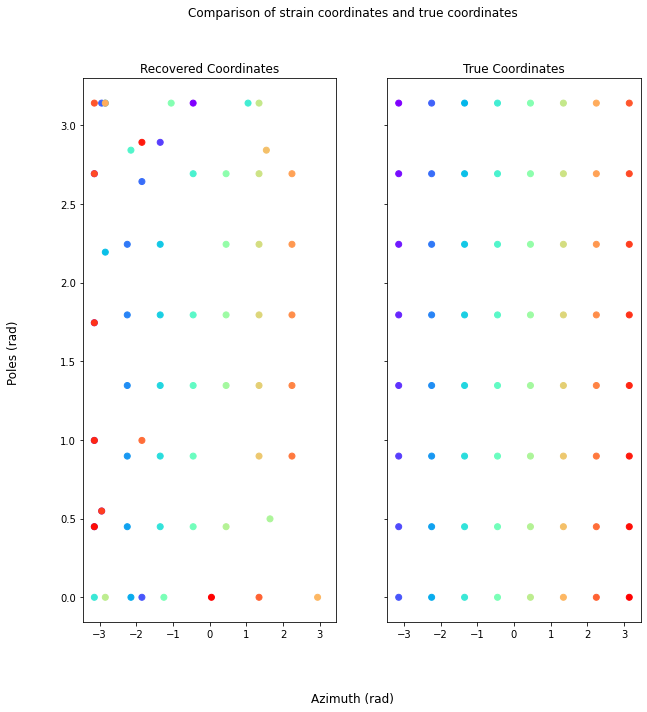

In [8]:
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0,1,len(azims)))
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Comparison of strain coordinates and true coordinates')
fig.supxlabel('Azimuth (rad)')
fig.supylabel('Poles (rad)')
ax1.set_title('Recovered Coordinates')
ax1.scatter(strain_azims, strain_poles, c=colors)
ax2.set_title('True Coordinates')
ax2.scatter(azims, poles, c=colors)
#plt.savefig(f'{newpath}/coordinate_comparison')
plt.show()

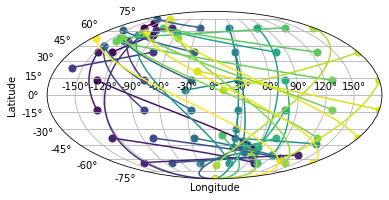

In [117]:
color_map = plt.cm.viridis(np.linspace(0, 1, len(azims)))

fig = plt.figure()
ax = fig.add_subplot(111, projection="mollweide")
for i in range(len(azims)):
    ax.scatter(strain_azims[i], np.array(strain_poles[i]) - np.pi/2, c=[color_map[i]], s=50, 
               vmin=0.8, vmax=1.0)
    ax.scatter(azims[i], np.array(poles[i]) - np.pi/2, c=[color_map[i]], s=50, 
               vmin=0.8, vmax=1.0)
    ax.plot([strain_azims[i], azims[i]], [np.array(strain_poles[i]) - np.pi/2, np.array(poles[i]) - np.pi/2],
            c=color_map[i])
ax.grid(True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("Best match for true signal coordinates")
#plt.savefig(f'{newpath}/coordinate_comparison_skymap')
plt.show()